# EI balance network

Implementation of the paper:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

**Neuron model**

In COBA network, each integrate-and-fire neuron is characterized by a time constant, $\tau$ = 20 ms, and a resting membrane potential, $V_{rest}$ = -60 mV. Whenever the membrane potential crosses a spiking threshold of -50 mV, an action potential is generated and the membrane potential is reset to the resting potential, where it remains clamped for a 5 ms refractory period. The membrane voltages are calculated as follows:

$$
\tau \frac{dV}{dt} = (V_{rest} - V) + I
$$

The $I$ is the synaptic input, which consists of two parts:

$$I = g_{exc}(E_{exc} - V) + g_{inh}(E_{inh} - V) + I_{ext}$$

where reversal potentials are $E_{exc} = 0$ mV and $E_{inh} = -80$ mV, $I_{ext}=20.$.

**Synapse model**

In COBA network, when a neuron fires, the appropriate synaptic variable of its postsynaptic targets are increased, $g_{exc} \gets g_{exc} + \Delta g_{exc}$ for an excitatory presynaptic neuron and $g_{inh} \gets g_{inh} + \Delta g_{inh}$ for an inhibitory presynaptic neuron. Otherwise, these parameters obey the following equations:

$$\tau_{exc} {dg_{exc} \over dt} = -g_{exc}$$
$$\tau_{inh} {dg_{inh} \over dt} = -g_{inh}$$

with synaptic time constants $\tau_{exc} = 5$ ms, $\tau_{inh} = 10$ ms, $\Delta g_{exc} = 0.6$ and $\Delta g_{inh} = 6.7$.

In [1]:
import numpy as np
import brainpy as bp

bp.backend.set(backend='numba')

In [2]:
# Parameters for network structure
num = 4000
num_exc = int(num * 0.75)
num_inh = int(num * 0.25)

In [3]:
# Parameters for the neuron
tau = 20  # ms
Vt = -50  # mV
Vr = -60  # mV
El = -60  # mV
ref_time = 5.0  # refractory time, ms
Iext = 20.

In [4]:
class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    

    def __init__(self, size, **kwargs):
        # variables
        self.V = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        # initialize
        self.int_V = bp.odeint(self.dev_V)
        super(LIF, self).__init__(size=size, **kwargs)
    
    @staticmethod
    def dev_V(V, t, Iexc):
        ???  # dvdt
        return dV
    
    def update(self, _t):
        for i in range(self.num):
            self.spike[i] = 0.
            if (_t - self.t_last_spike[i]) > ref_time:
                V = self.int_V(self.V[i], _t, self.input[i])
                if V >= Vt:
                    # logic when neuron fires
                    self.V[i] = ???
                    self.spike[i] = ???
                    self.t_last_spike[i] = ???
                else:
                    # logic when neuron does not fire
                    self.V[i] = ???
            self.input[i] = Iext

In [5]:
# Parameters for the synapse
tau_exc = 5  # ms
tau_inh = 10  # ms
E_exc = 0.  # mV
E_inh = -80.  # mV
delta_exc = 0.6  # excitatory synaptic weight
delta_inh = 6.7  # inhibitory synaptic weight

In [6]:
class Syn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    @staticmethod
    def dev_g(g, t, tau):
        ??? # dgdt 
        return dg

    def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
        # parameters
        self.tau = tau
        self.weight = weight
        self.E = E

        # connections
        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = self.conn.requires('pre_ids', 'post_ids')
        self.num = len(self.pre_ids)

        # variables
        self.g = bp.ops.zeros(self.num)

        # initialize
        self.int_g = bp.odeint(self.dev_g)
        super(Syn, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.g = ??? # integral
        
        # p1: update
        for syn_i in range(self.num):
            pre_i = self.pre_ids[syn_i]
            if self.pre.spike[pre_i]:
                self.g[syn_i] = ???  # if pre neuron spikes
        # p2: output
        for syn_i in range(self.num):
            post_i = self.post_ids[syn_i]
            self.post.input[post_i] += self.g[syn_i] * ??? # 

Compilation used 2.7974 s.
Start running ...
Run 10.0% used 0.187 s.
Run 20.0% used 0.373 s.
Run 30.0% used 0.559 s.
Run 40.0% used 0.750 s.
Run 50.0% used 0.972 s.
Run 60.0% used 1.164 s.
Run 70.0% used 1.361 s.
Run 80.0% used 1.558 s.
Run 90.0% used 1.754 s.
Run 100.0% used 1.989 s.
Simulation is done in 1.989 s.



C:\Users\adadu\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


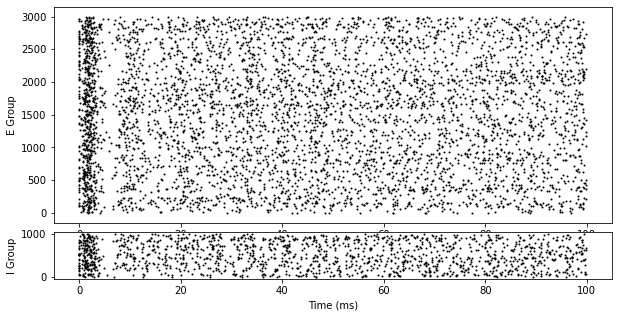

In [7]:
E = LIF(size=???, monitors=???)  # monitor neuron spike
E.V = np.random.randn(num_exc) * 5. + Vr

I = LIF(size=???, monitors=???)
I.V = np.random.randn(num_inh) * 5. + Vr

E2E = Syn(pre=???, post=???, conn=???, tau=tau_exc, weight=delta_exc, E=E_exc)

E2I = Syn(pre=???, post=???, conn=???, tau=tau_exc, weight=delta_exc, E=E_exc)

I2E = Syn(pre=???, post=???, conn=???, tau=tau_inh, weight=delta_inh, E=E_inh)

I2I = Syn(pre=???, post=???, conn=???, tau=tau_inh, weight=delta_inh, E=E_inh)

net = bp.Network(E, I, E2E, E2I, I2E, I2I)
t = net.run(100., report=True)

fig, gs = bp.visualize.get_figure(row_num=5, col_num=1, row_len=1, col_len=10)
fig.add_subplot(gs[:4, 0])
bp.visualize.raster_plot(E.mon.ts, E.mon.spike, ylabel='E Group', xlabel='')
fig.add_subplot(gs[4, 0])
bp.visualize.raster_plot(I.mon.ts, I.mon.spike, ylabel='I Group', show=True)